
Optionals: 
1. We might need to implement random data at the end of the project.

# Import of Important Library, Network and Meta Data

In [1]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Import Network data
networkData = pd.read_csv('TD3_primary_undirected_temporal.csv')
networkData

,time,node-i,node-j
0,0,58,63
1,0,59,64
2,0,63,66
3,0,85,190
4,0,85,214
...,...,...,...
125768,3099,152,172
125769,3099,152,174
125770,3099,167,180
125771,3099,172,178


In [3]:
# Import MetaData [information on the nodes (class, gender)]
metadata = pd.read_csv("TD3_primary_metadata.csv")
metadata

,node-index,class,gender
0,0,5B,M
1,1,5B,F
2,2,5B,M
3,3,5B,F
4,4,5B,M
...,...,...,...
237,237,2A,M
238,238,2A,F
239,239,2A,M
240,240,1B,F


# Initialisation of Simulation


1. 1 / alpha : latent period of virus
2. 1 / gamma : mean infectious period
3. beta : contact rate

In [4]:
ALPHA = 1 #S -> E
BETA = 0.1  #E -> I
GAMMA = 0.01 #I -> R

## Flags of State of Nodes
SUSCEPTIBLE = 1
EXPOSED = 2
INFECTIOUS = 3
RECOVERED = 4

# Simulation

In [5]:
tMax = networkData['time'].max()

numOfNodes = metadata.shape[0]
print("Number of Nodes: ", numOfNodes)

#Initialisation of Status Matrix, where everyone is susceptible.
statusMatrix = np.full((tMax+1, numOfNodes), SUSCEPTIBLE)
print(statusMatrix.shape)

Number of Nodes:  242
(3100, 242)


In [6]:
NUMOFPATIENTZERO = int(0.25*numOfNodes)
np.random.seed(0)
patientZerosArray = np.random.randint(0, numOfNodes, size=NUMOFPATIENTZERO)
for patientZero in patientZerosArray:
    statusMatrix[0][patientZero] = EXPOSED

print(statusMatrix[0])

[1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 2 2 1 2 2 1 2 1 2
 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 2 1 2 1
 1 1 1 2 1 2 1 2 2 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 1 1 1 1
 1 1 1 2 2 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 2
 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 1 1 1 1 2 1 2 2 1 2 1 1 1 1 1 2 1
 2 1 1 1 1 1 1 2 2 1 2 1 2 1 1 1 1 2 2 1 1 1 1 2 1 1 2 1 1 1 1 2 1 1 1 1 1
 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1]


In [7]:
from collections import defaultdict
edgesDictionaryWRTTime = [defaultdict(list) for time in range(0, tMax + 1)]

for time, node_i, node_j in networkData.values:
    edgesDictionaryWRTTime[time][node_i].append(node_j)
    edgesDictionaryWRTTime[time][node_j].append(node_i)
print(edgesDictionaryWRTTime[0])

defaultdict(<class 'list'>, {58: [63], 63: [58, 66], 59: [64], 64: [59], 66: [63], 85: [190, 214], 190: [85], 214: [85, 191], 102: [115], 115: [102], 191: [199, 214], 199: [191]})


In [8]:
rand = lambda proba, numOfNodes: np.random.uniform(0, 1, size=numOfNodes) < proba

In [9]:
def random_vaccination_strategy(timestep, statusMatrix, proportionToVax): 
    susceptiblePopulation = np.where(statusMatrix[timestep] == SUSCEPTIBLE)[0]
    newlyVaccinated = susceptiblePopulation[rand(proportionToVax, len(susceptiblePopulation))]
    statusMatrix[timestep, newlyVaccinated] = RECOVERED
    return statusMatrix

In [10]:
VAX_TIMESTEPS = [50]
for t in range(tMax):
    
    # Now vaccinating at timesteps near you ...
    if t in VAX_TIMESTEPS: 
        statusMatrix = random_vaccination_strategy(t, statusMatrix, proportionToVax=0.1)
    
    statusMatrix[t+1] = statusMatrix[t]
    exposedPopulation = np.where(statusMatrix[t]==EXPOSED)[0]
    newlyInfectious = exposedPopulation[rand(ALPHA,len(exposedPopulation))]
    statusMatrix[t+1, newlyInfectious] = INFECTIOUS

    InfectiousPopulation = np.where(statusMatrix[t]==INFECTIOUS)[0]
    riskContact = np.array([node_j for node_i in InfectiousPopulation for node_j in edgesDictionaryWRTTime[t][node_i] if statusMatrix[t,node_j]==SUSCEPTIBLE], dtype=int)
    newlyExposed = riskContact[rand(BETA, len(riskContact))]
    statusMatrix[t+1, newlyExposed] = EXPOSED
    
    newlyRecovered = InfectiousPopulation[rand(GAMMA, len(InfectiousPopulation))]
    statusMatrix[t+1, newlyRecovered] = RECOVERED

    
print(np.where(statusMatrix[tMax]==RECOVERED)[0])

[  0   1   2   3   4   5   7   8   9  10  11  13  14  15  16  17  18  19
  21  23  24  25  26  28  29  30  31  32  33  34  36  37  38  39  40  41
  43  44  45  46  47  48  49  50  51  52  53  54  56  57  58  59  61  62
  63  64  65  66  67  68  69  70  71  72  74  75  76  77  78  79  80  81
  82  83  84  85  87  88  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 121 122
 125 126 127 128 130 132 134 135 137 138 139 140 141 142 143 144 146 147
 148 149 151 153 154 155 156 157 158 160 161 162 163 164 165 166 167 169
 170 171 172 173 174 175 176 177 178 179 183 184 185 187 188 189 190 192
 193 194 195 197 198 199 200 202 203 204 205 206 207 208 209 210 211 212
 214 215 216 217 218 219 220 223 224 225 226 227 228 229 230 231 232 234
 235 236 237 238 239 240 241]


In [11]:
# Plotting the growth of S, E, I and R populations
listPopulations = [] # List of dicts, indexed by timestep #np.zeros(shape=(tMax))
print(statusMatrix[1])
for timestep in range(tMax):
    temp = np.unique(statusMatrix[timestep], return_counts=True)
    #print(temp)
    listPopulations.append( dict(zip(temp[0], temp[1])) )

listPopulations = pd.DataFrame.from_dict(listPopulations).fillna(0).astype(int)
print(listPopulations.head())
# Do this at your own risk.
# print(listPopulations)

[1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 3 1 1 3 3 1 3 3 1 3 1 3
 1 1 3 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 3 1 1 3 1 3 1
 1 1 1 3 1 3 1 3 3 1 1 1 1 3 3 1 1 1 1 1 1 1 1 1 1 3 1 1 1 3 1 1 1 1 1 1 1
 1 1 1 3 3 1 3 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 3 1 3 1 1 1 1 3
 3 1 1 3 1 1 1 1 1 1 1 1 1 1 1 3 1 3 1 3 1 1 1 1 3 1 3 3 1 3 1 1 1 1 1 3 1
 3 1 1 1 1 1 1 3 3 1 3 1 3 1 1 1 1 3 3 1 1 1 1 3 1 1 3 1 1 1 1 3 1 1 1 1 1
 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1]
     1   2   3  4
0  191  51   0  0
1  191   0  51  0
2  191   0  50  1
3  190   1  50  1
4  190   0  50  2


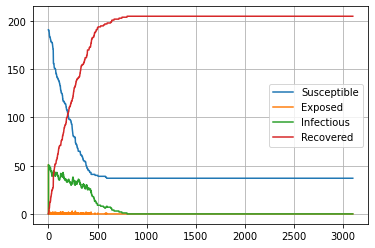

In [12]:
# Now we're plotting things
listPopulations.rename(columns={1 : "Susceptible", 2: "Exposed", 3: "Infectious", 4: "Recovered"}, inplace=True)
listPopulations.plot()
plt.legend()
plt.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


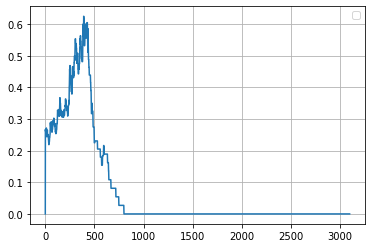

In [13]:
plt.plot (listPopulations['Infectious']/listPopulations['Susceptible'])
plt.legend()
plt.grid()